# Imports

Magic notebook boxes

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import from external libraries

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import gudhi as gd
import tensorflow as tf
import networkx as nx
#from statmapper import mapper2networkx

Imports from utils files

In [3]:
import utils_expe as uexpe
import utils_tda  as utda
#from utils_expe import *
#from utils_tda import *

vineyards not available. Set use_vineyards to False.


# Toboggan

we first define a very specific function

In [ ]:
def f(x, a, b, p, q, version):
    if version==1:
        return a * np.abs(x[0])**p + b * np.abs(x[1])**q
    elif version==2:
        return a * np.log(1 + np.abs(x[0])**p) + b * np.abs(x[1])**q


def grad_f(x, a, b, p, q, version):
    u, v = x
    if u <= 0:
        if v <= 0:
            if version==1:
                return np.array([- a * p * (-u)**(p-1), - b * q * (-v)**(q-1)])
            elif version==2:
                return np.array([- a * p * (-u)**(p-1) / (1 + (-u)**p), - b * q * (-v)**(q-1)])
        else:
            if version==1:
                return np.array([- a * p * (-u)**(p-1), b * q * v**(q-1)])
            elif version==2:
                return np.array([- a * p * (-u)**(p-1) / (1 + (-u)**p), b * q * (v)**(q-1)])

    elif v <= 0:
        if version==1:
            return np.array([ a * p * u**(p-1), - b * q * (-v)**(q-1)])
        elif version==2:
            return np.array([a * p * (u)**(p-1) / (1 + (u)**p), - b * q * (-v)**(q-1)])
    else:
        if version==1:
            return np.array([a * p * u**(p-1), b * q * v**(q-1)])
        elif version==2:
            return np.array([a * p * (u)**(p-1) / (1 + (u)**p), b * q * (v)**(q-1)])

        
def strat_f(x, eps):
    u, v = x
#     if np.abs(u) < eps:  # we are near the boundary between the two strata
#         return [np.array([-u / np.abs(u) * min(eps - np.abs(u), np.abs(u)), v])]
#     else:
#         return []
    if np.abs(u) < eps:
        return np.array([x, np.array([-u, v])])
    else:
        return np.array([x])

    
def random_around(x, eps, nb_pts=2):
    thetas = 2 * np.pi * np.random.rand(nb_pts)
    xx = eps * np.array([np.cos(thetas), np.sin(thetas)]).T
    # print("shape : ", xx.shape)
    return np.vstack([x, x + xx])

In [ ]:
def _grad_update(x, grad, lr):
    return x - lr * grad


def grad_descent_vanilla(x0, lr, grad_f, nb_step, verbose=1):
    current_point = x0
    res = []
    for t in range(nb_step):
        g = grad_f(current_point)
        new_current_point = _grad_update(current_point, g, lr / (t+1))

        res.append(current_point)
        current_point = new_current_point
    if verbose >= 1:
        print("Vanilla, nb step done:", t)

    return np.array(res)

In [ ]:
def grad_sampling(f, grad_f, params, crit=1E-3):
    x0 = params['x0']
    eps = params['eps']
    eta = params['eta']
    beta = params['beta']
    gamma = params['gamma']
    nb_max_step_1 = params['nb_max_step_1']
    nb_max_step_2 = params['nb_max_step_2']
    
    # Store the resulting sequence of positions built
    res = []

    # Init the params
    xk = x0
    
    for t in range(nb_max_step_1):

        Gk = []
        for x_sample in random_around(xk, eps):  # Enumerate over strata containing xk
            grad_k = grad_f(x_sample)
            Gk.append(grad_k)
        pref_grad_k = utda.min_norm_on_convex_hull(np.array(Gk))
        norm_grad_k = np.linalg.norm(pref_grad_k)

        if norm_grad_k < eta:
            print("Sampling Converged after %s steps" %t)
            res.append(xk)
            return res, t

        tk = eps
        for t2 in range(nb_max_step_2):
            new_xk = xk - tk * pref_grad_k / norm_grad_k

            if f(new_xk) > f(xk) - beta * tk * norm_grad_k:
                tk = gamma * tk
            else:
                xk = new_xk
                res.append(xk)
                break
        
    print("Sampling did not converged after %s steps" %nb_max_step_1)
    return res, np_max_step_1

In [ ]:
def jacob_grad(f, grad_f, strat_f, params, crit=1E-3):
    x0 = params['x0']
    eps = params['eps']
    eta = params['eta']
    beta = params['beta']
    gamma = params['gamma']
    nb_max_step_1 = params['nb_max_step_1']
    nb_max_step_2 = params['nb_max_step_2']

    # Store the resulting sequence of positions built
    res = []

    # Init the params
    xk = x0
    
    for t in range(nb_max_step_1):
        eps_k = eps

        for t2 in range(nb_max_step_2):
            Gk = []
            for x_strata in strat_f(xk, eps):  # Enumerate over stratum containing xk
                grad_k = grad_f(x_strata)
                Gk.append(grad_k)
            pref_grad_k = utda.min_norm_on_convex_hull(np.array(Gk))
            norm_grad_k = np.linalg.norm(pref_grad_k)

            if norm_grad_k < eta:
                print("Stratified Converged after %s steps" %t)
                res.append(xk)
                return res

            new_xk = xk - eps_k * pref_grad_k / norm_grad_k

            if f(new_xk) > f(xk) - beta * eps_k * norm_grad_k:
                eps_k = gamma * eps_k
            else:
                xk = new_xk
                res.append(xk)
                break
        
    print("Stratified did not converged after %s steps" %nb_max_step_1)
    return res

In [ ]:
a, b = 20, 1
p, q = 1, 2
version = 2

f_reduced = lambda x: f(x, a, b, p, q, version=version)
grad_f_reduced = lambda x: grad_f(x, a, b, p, q, version=version)


x0 = np.array([.8,.8])

# For the plot
x, y = np.linspace(-1, 1), np.linspace(-.5, 1.5)
X, Y = np.meshgrid(x, y)

Z = f_reduced([X,Y])

lr = .1
res_vanilla = grad_descent_vanilla(x0, lr, grad_f_reduced, nb_step=100000)
Zres_vanilla = np.array([f_reduced(x) for x in res_vanilla])

# param definition
eps = .1  # distance from which we are looking if there are other strata.
eta = 0.01  # algorithm stops if the norm of the generalized gradient goes under this.
beta = 0.1  # control the decent rate (?)
gamma = 0.9  # decrease factor for epsilon (?)
params = {'x0':x0, 'eps':eps, 'eta':eta, 'beta':beta, 'gamma':gamma, 
          'nb_max_step_1':50, 'nb_max_step_2':100}

res_sampling, _  = np.array(grad_sampling(f_reduced, grad_f_reduced, params))
Zres_sampling = np.array([f_reduced(x) for x in res_sampling])

res_stratified = np.array(jacob_grad(f_reduced, grad_f_reduced, strat_f, params))

# For the plot
Zres_stratified = np.array([f_reduced(x) for x in res_stratified])

In [ ]:
ts = np.zeros(100)
for i in range(100):
    res_sampling, t  = np.array(grad_sampling(f_reduced, grad_f_reduced, params))
    ts[i] = t
    
print(np.mean(ts))

In [ ]:
np.std(ts)

In [ ]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax3 = fig.add_subplot(1,3,3, projection='3d')

axs = [ax1, ax2, ax3]

[ax.plot_surface(X, Y, Z, alpha=0.5) for ax in axs]

ax1.scatter(res_vanilla[:,0], res_vanilla[:,1], Zres_vanilla, color='red', s=100, label='Vanilla')
ax1.plot(res_vanilla[:,0], res_vanilla[:,1], Zres_vanilla, color='red')
# ax.set_axis_off()

ax2.scatter(res_sampling[:,0], res_sampling[:,1], Zres_sampling, color='black', s=100, label='Sampling')
ax2.plot(res_sampling[:,0], res_sampling[:,1], Zres_sampling, color='black')


ax3.scatter(res_stratified[:,0], res_stratified[:,1], Zres_stratified, color='green', s=100, label='Stratified')
ax3.plot(res_stratified[:,0], res_stratified[:,1], Zres_stratified, color='green')

elev=40
azim=90

[ax.legend() for ax in axs]
[ax.view_init(elev=elev, azim=azim)]

In [ ]:
np.save('./save_repo/surface.npy', np.array([X,Y,Z]))
np.save('./save_repo/res_vanilla.npy', np.hstack([res_vanilla, Zres_vanilla[:,np.newaxis]]))
np.save('./save_repo/res_sampling.npy', np.hstack([res_sampling, Zres_sampling[:,np.newaxis]]))
np.save('./save_repo/res_stratified.npy', np.hstack([res_stratified, Zres_stratified[:,np.newaxis]]))

# Minimization of Total Persistence p=1

In [4]:
model = '1Drandom'

In [5]:
np.random.seed(1)
N = 5
F, Finit, stbase, stbase_obs = uexpe.build_model(N=N, model=model)

In [6]:
Finit
# Finit = 0.0001 * np.random.rand(N)

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, 3.02332573e-01,
       1.46755891e-01])

In [7]:
L = uexpe.build_persistence_diagrams(F, Finit, stbase, model, dim=0, stbase_obs=stbase_obs)

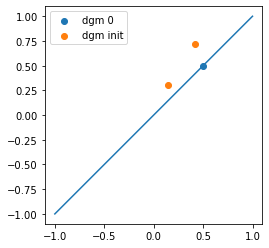

In [8]:
uexpe.plot_diagrams(L, -1,1,-1,1)

No handles with labels found to put in legend.


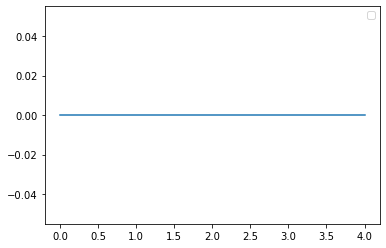

No handles with labels found to put in legend.


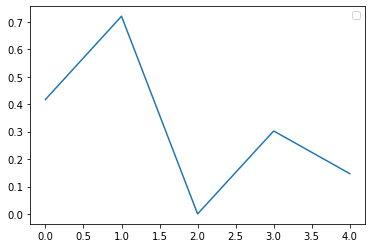

In [9]:
uexpe.plot_functions([F[:,i] for i in range(F.shape[1])] + [Finit], model)

Work

In [10]:
# ***** Param that should not be changed. ***** # 

dim = 0                    # homological dimension
card_dgm_max = 5           # padding value for diagram points
max_dict_size = 500        # max number of strata to keep in memory
order = 1.                 # loss is given by W_order^order. Pick order=1. or order=2.
internal_p = 2             # Internal p (ground metric) used in Wasserstein computation. Default is np.inf, 
                           # but 2 may be better.
epsilon_tmp = 1e-2             # we search for strata by looking at miror points in range 2*epsilon
eta = 1e-2                 # stopping criterion for (generalized) gradient norm
lipschitz = 1.             # upperbound on the Lipschitz constant
gamma = 0.5                # params in the algorithm for epsilon reduction
beta = 0.5                 # params in the algorithm for sufficient descent criterion
heuristic = 'dijkstra'     # primary heuristic to get strata
cp_heuristic = 'dijkstra'  # secondary heuristic to get strata if primary heuristic is 'memoization'
use_vineyards = False      # whether to compute PDs with vineyards (must be True only if use_strata is True!!)
use_memoization = False     # whether to memorize PDs

extended = True            # whether to use extended persistence

Pick verbosity level.

In [11]:
verbosity_level = 1        # 0 : mostly silent, 1 : standard, 2 : debug helper

Chose the mode.

In [12]:
mode = 'gradient_sampling'            # 'vanilla', 'strata' or 'gradient_sampling'
#mode = 'strata'                        # 'vanilla', 'strata' or 'gradient_sampling'
#mode = 'vanilla'

In [13]:
decay = False              # Only useful if mode == 'vanilla'
normalize_gradient = True   # Only useful of mode == 'vanilla' or mode == 'gradient_sampling'

In [14]:
if mode == "gradient_sampling": 
    card_strata = N+1            # maximal number of strata we investigate
    epsilon = epsilon_tmp / 2        # To make strata and gradient_sampling comparable
elif mode == "strata":
    card_strata = min(np.math.factorial(N), 120)
    epsilon = epsilon_tmp
elif mode == "vanilla":
    card_strata = 0
    epsilon = epsilon_tmp/2

In [15]:
params = {'dim': dim,
          'card_dgm_max': card_dgm_max, 
          'max_dict_size': max_dict_size,
          'order':order,
          'internal_p': internal_p,
          'card_strata':card_strata,
          'epsilon':epsilon,
          'eta':eta,
          'lipschitz':lipschitz,
          'gamma':gamma,
          'beta': beta,
          'heuristic':heuristic,
          'complementary_heuristic':cp_heuristic,
          'use_vineyards': use_vineyards,
          'use_memoization': use_memoization,
          'extended': extended,
          'mode' : mode, 
          'verbosity_level': verbosity_level, 
          'normalize_gradient': normalize_gradient,
          'vanilla_decay': decay
         }

In [16]:
topomean = utda.TopoMeanModel(F=tf.Variable(initial_value=Finit, trainable=True), L=L[:-1], 
                              simplex=stbase,
                         params=params)

Let's now define the optimizer.

In [17]:
if mode == 'strata' or mode == 'gradient_sampling':
    learning_rate = 1.

elif mode == 'vanilla':
    learning_rate = epsilon

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

Finally, let Tensorflow do its magic!

Theo: TODO: écrire un script qui enregistre dans un `.txt` les paramètres avec lesquels on run le code quand on fera des expé sérieuses. Sinon on va jamais se rappeler des param utilisés dans les différentes expés.

In [18]:
np.set_printoptions(threshold=sys.maxsize)

num_epochs = 300
loop_epsilon = True
stopping_criterion = False

dgms, gradients, funcs = [], [], []

for epoch in range(num_epochs+1):
    
    continue_iterations, gradient = utda.compute_gradient(epoch, 
                                                          dgms, 
                                                          gradients, 
                                                          funcs, 
                                                          topomean, 
                                                          loop_epsilon)
    
    utda.apply_gradient(gradient, optimizer, topomean)
    
    if not continue_iterations:
        break

Epoch 0 

*****

After epoch 0:
Loss = 1.01244
Gradient norm = 2.64575

*****

Epoch 1 

*****

After epoch 1:
Loss = 0.99921
Gradient norm = 2.64575

*****

Epoch 2 

*****

After epoch 2:
Loss = 0.98599
Gradient norm = 2.64575

*****

Epoch 3 

*****

After epoch 3:
Loss = 0.97276
Gradient norm = 2.64575

*****

Epoch 4 

*****

After epoch 4:
Loss = 0.95953
Gradient norm = 2.64575

*****

Epoch 5 

*****

After epoch 5:
Loss = 0.94630
Gradient norm = 2.64575

*****

Epoch 6 

*****

After epoch 6:
Loss = 0.93307
Gradient norm = 2.64575

*****

Epoch 7 

*****

After epoch 7:
Loss = 0.91984
Gradient norm = 2.64575

*****

Epoch 8 

*****

After epoch 8:
Loss = 0.90661
Gradient norm = 2.64575

*****

Epoch 9 

*****

After epoch 9:
Loss = 0.89338
Gradient norm = 2.64575

*****

Epoch 10 

*****

After epoch 10:
Loss = 0.88016
Gradient norm = 2.64575

*****

Epoch 11 

*****

After epoch 11:
Loss = 0.86693
Gradient norm = 2.64575

*****

Epoch 12 

*****

After epoch 12:
Loss = 0.85370


*****

After epoch 102:
Loss = 0.16224
Gradient norm = 0.64550

*****

Epoch 103 

*****

After epoch 103:
Loss = 0.15902
Gradient norm = 0.64550

*****

Epoch 104 

*****

After epoch 104:
Loss = 0.15658
Gradient norm = 0.70711

*****

Epoch 105 

*****

After epoch 105:
Loss = 0.15434
Gradient norm = 1.00000

*****

Epoch 106 

*****

After epoch 106:
Loss = 0.15225
Gradient norm = 0.64550

*****

Epoch 107 

*****

After epoch 107:
Loss = 0.14897
Gradient norm = 0.65465

*****

Epoch 108 

*****

After epoch 108:
Loss = 0.14575
Gradient norm = 0.64550

*****

Epoch 109 

*****

After epoch 109:
Loss = 0.14247
Gradient norm = 0.65465

*****

Epoch 110 

*****

After epoch 110:
Loss = 0.13925
Gradient norm = 0.64550

*****

Epoch 111 

*****

After epoch 111:
Loss = 0.13603
Gradient norm = 0.64550

*****

Epoch 112 

*****

After epoch 112:
Loss = 0.13280
Gradient norm = 0.64550

*****

Epoch 113 

*****

After epoch 113:
Loss = 0.12957
Gradient norm = 0.64550

*****

Epoch 114 

***

Visu

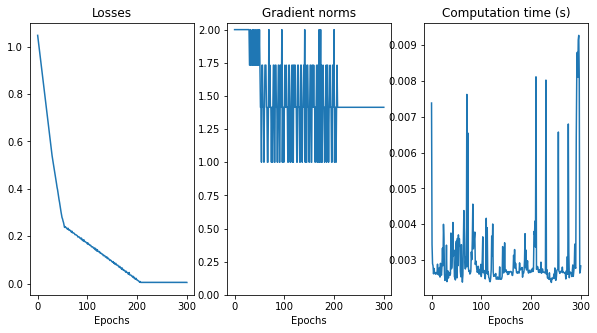

In [128]:
uexpe.plot_curves(topomean.losseslist, gradients, topomean.times)
#print(dgms[:10], funcs[:10], gradients[:10])

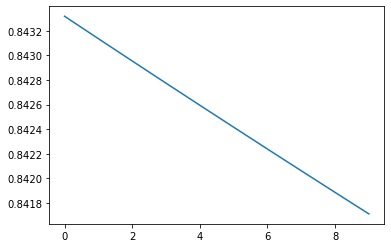

In [70]:
fig, ax = plt.subplots()
ax.plot(topomean.losseslist[-10:])

In [19]:
np.sum(topomean.times)

2.631959915161133

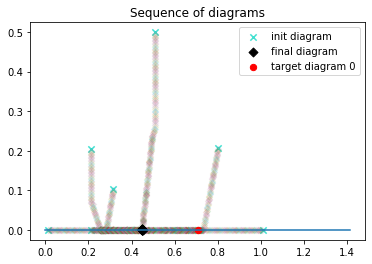

In [49]:
uexpe.plot_sequence_of_diagrams(dgms, L, every=1)

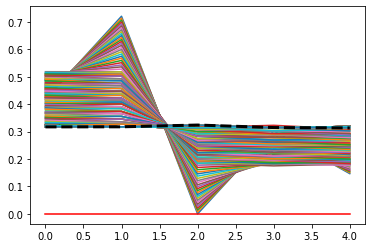

In [91]:
fig, ax = plt.subplots()
for t,f in enumerate(funcs):
    ax.plot(f, label='t = %s'%t) #, color='blue', alpha=(1 - t/100))
ax.plot(F, color='red')
ax.plot(funcs[-1], color='k', linewidth=3, linestyle="dashed", label='final func')
#ax.legend()

### Saving. Bewayre you don't do stupid stuff. 

In [129]:
### Saving. Bewayre you don't do stupid stuff. 

# Short trick for better filename managing
if mode == 'vanilla' and decay:
    mode = 'vanilla_decay'

path = './save_repo/poc_N=%s_' %N + mode + '_'
print(path)

./save_repo/poc_N=5_vanilla_


In [130]:
np.save(path + 'diags.npy', dgms)
np.save(path + 'losses.npy', topomean.losseslist)
np.save(path + 'grads_norms.npy', np.array([g[1] for g in gradients]))
np.save(path + 'grads_values.npy', np.array([g[0] for g in gradients]))
np.save(path + 'funcs.npy', funcs)# Short trick for better filename managing

# Template Registration experiment

Now, we define the list of functions which we will compute the topological mean of, as well as some initial function values (that are going to be optimized). To this end, we first define the underlying simplicial complex with a simplex tree `stbase`, whose function values on the vertices are going to be optimized.

Recommended values : 
- 'circle': N = 100
- 'peaks': N = 10
- 'random': N = 1000
- 'FCcircle': N=6 (actually hard-coded here).

In [464]:
model = 'templateRegistration'

In [482]:
np.random.seed(42)
N = 4

In [483]:
F, Finit, stbase, stbase_obs = uexpe.build_model(N, model)

[0.33 0.61 0.31 0.72]


In [484]:
if N != 4:
    Finit = np.random.rand(N)

In [485]:
L = uexpe.build_persistence_diagrams(F, Finit, stbase, model, dim=0, ext=True, stbase_obs=stbase_obs)

### Visualization

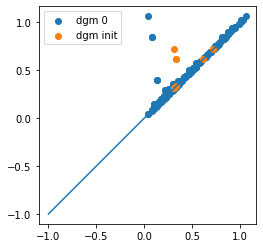

In [486]:
uexpe.plot_diagrams(L, -1,1,-1,1)

No handles with labels found to put in legend.


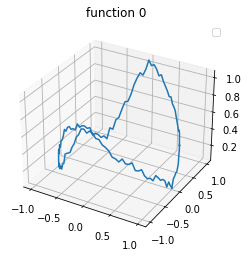

No handles with labels found to put in legend.


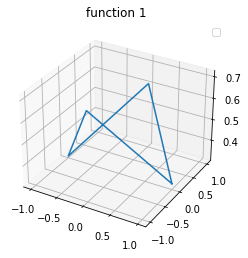

In [487]:
uexpe.plot_functions([F, Finit], model)

### Optimization

We can proceed with the optimization. Let's first initialize the network.

Tips: 

+ when epsilon is small and k is small, we go close to minimum but then we can go away. Indeed, if, eg, the true minimum is attained when all vertex values are the same, then there are a HUGE number of strata around the true min. Hence a min on convex hull for just a few strata is likely to be big.

+ when epsilon is large, crazy things happen because we try to use crazy strata.

+ hence it seems that the best is epsilon small and k large (at least in the situation described in first bullet).

+ when persistence diagram points are close, funny things happen because positive simplices of different points can be swapped in close strata. Otherwise, we reproduce vanilla.

In [488]:
dim = 0                    # homological dimension
card_dgm_max = 50          # padding value for diagram points
max_dict_size = 500        # max number of strata to keep in memory
order = 2.                 # loss is given by W_order^order. Pick order=1. or order=2.
internal_p = 2.
use_strata = True          # if False, run vanilla, otherwise look at strata
card_strata = 100           # maximal number of strata we investigate
epsilon = 1e-2             # we search for strata by looking at miror points in range 2*epsilon
eta = 1e-2                 # stopping criterion for (generalized) gradient norm
lipschitz = 1.             # upperbound on the Lipschitz constant
gamma, beta = 0.5, 0.5     # params in the algorithm for epsilon reduction
heuristic = 'dijkstra'     # primary heuristic to get strata
cp_heuristic = 'dijkstra'  # secondary heuristic to get strata if primary heuristic is 'memoization'
use_vineyards = False       # whether to compute PDs with vineyards (must be True only if use_strata is True!!)
use_memoization = True     # whether to memorize PDs
extended = True            # whether to use extended persistence
verbosity_level = 1

In [489]:
mode = "strata"

In [490]:
params = {'dim': dim,
          'card_dgm_max': card_dgm_max, 
          'max_dict_size': max_dict_size,
          'order':order,
          'internal_p': internal_p,
          'use_strata':use_strata,
          'card_strata':card_strata,
          'epsilon':epsilon,
          'eta':eta,
          'lipschitz':lipschitz,
          'gamma':gamma,
          'beta': beta,
          'heuristic':heuristic,
          'complementary_heuristic':cp_heuristic,
          'use_vineyards': use_vineyards,
          'use_memoization': use_memoization, 
          'extended': extended,
          'mode': mode, 
          'verbosity_level': verbosity_level}

In [491]:
topomean = utda.TopoMeanModel(F=tf.Variable(initial_value=Finit, trainable=True), L=L[:-1], simplex=stbase,
                         params=params)

Let's now define the optimizer.

In [492]:
learning_rate = 1.  # should be 1.
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

Finally, let Tensorflow do its magic!

Theo: TODO: écrire un script qui enregistre dans un `.txt` les paramètres avec lesquels on run le code quand on fera des expé sérieuses. Sinon on va jamais se rappeler des param utilisés dans les différentes expés.

In [493]:
np.set_printoptions(threshold=sys.maxsize)

num_epochs = 150
delta, num = 1e-3, 2
use_long_range_strata = False
loop_epsilon = True

dgms, gradients, funcs = [], [], []
for epoch in range(num_epochs+1):
    
    continue_iterations, gradient = utda.compute_gradient(epoch, 
                                                          dgms, 
                                                          gradients, 
                                                          funcs, 
                                                          topomean, 
                                                          loop_epsilon)
    
    utda.apply_gradient(gradient, optimizer, topomean)

    if not continue_iterations:
        break

Epoch 0 
Found 1 new permutations, 0 already recorded permutations, among 1 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 1
Computing gradient over 1 strata
Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 0:
Loss = 0.52522
Gradient norm = 1.64171

*****

Epoch 1 
Found 0 new permutations, 1 already recorded permutations, among 1 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 1
Computing gradient over 1 strata
Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 1:
Loss = 0.51706
Gradient norm = 1.62454

*****

Epoch 2 
Found 0 new permutations, 1 already recorded permutations, among 1 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 1
Computing gradient over 1 strata
Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 2:
Loss = 0.50898
Gradient nor

Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 26:
Loss = 0.34221
Gradient norm = 1.19939

*****

Epoch 27 
Found 0 new permutations, 2 already recorded permutations, among 2 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 2
Computing gradient over 2 strata
Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 27:
Loss = 0.33625
Gradient norm = 1.18402

*****

Epoch 28 
Found 0 new permutations, 2 already recorded permutations, among 2 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 2
Computing gradient over 2 strata
Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 28:
Loss = 0.33037
Gradient norm = 1.16868

*****

Epoch 29 
Found 0 new permutations, 2 already recorded permutations, among 2 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 2
Computi

Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 51:
Loss = 0.21600
Gradient norm = 0.82257

*****

Epoch 52 
Found 0 new permutations, 2 already recorded permutations, among 2 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 2
Computing gradient over 2 strata
Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 52:
Loss = 0.21193
Gradient norm = 0.80786

*****

Epoch 53 
Found 0 new permutations, 2 already recorded permutations, among 2 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 2
Computing gradient over 2 strata
Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 53:
Loss = 0.20792
Gradient norm = 0.79318

*****

Epoch 54 
Found 0 new permutations, 2 already recorded permutations, among 2 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 2
Computi

Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 77:
Loss = 0.13344
Gradient norm = 0.45225

*****

Epoch 78 
Found 0 new permutations, 2 already recorded permutations, among 2 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 2
Computing gradient over 2 strata
Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 78:
Loss = 0.13121
Gradient norm = 0.43862

*****

Epoch 79 
Found 0 new permutations, 2 already recorded permutations, among 2 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 2
Computing gradient over 2 strata
Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 79:
Loss = 0.12905
Gradient norm = 0.42503

*****

Epoch 80 
Found 0 new permutations, 2 already recorded permutations, among 2 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 2
Computi

Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 102:
Loss = 0.09743
Gradient norm = 0.13182

*****

Epoch 103 
Found 0 new permutations, 2 already recorded permutations, among 2 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 2
Computing gradient over 2 strata
Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 103:
Loss = 0.09680
Gradient norm = 0.12015

*****

Epoch 104 
Found 0 new permutations, 2 already recorded permutations, among 2 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 2
Computing gradient over 2 strata
Had to reduce epsilon 0 times, which took 0.000 secs

*****

After epoch 104:
Loss = 0.09623
Gradient norm = 0.10860

*****

Epoch 105 
Found 0 new permutations, 2 already recorded permutations, among 2 permutations in the permutahedron obtained with heuristic dijkstra
Number of recorded permutations is now 2
C

### Curves vizu

Let's visualize losses and diagrams.

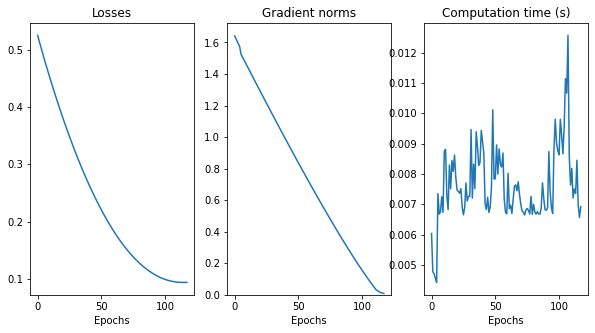

In [494]:
uexpe.plot_curves(topomean.losseslist, gradients, topomean.times)
#print(dgms[:10], funcs[:10], gradients[:10])

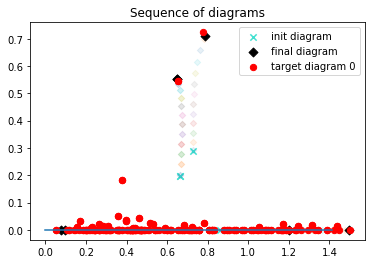

In [495]:
uexpe.plot_sequence_of_diagrams(dgms, L)

IndexError: list index out of range

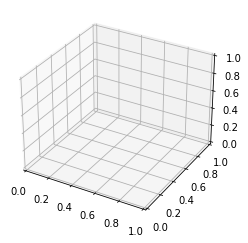

In [317]:
uexpe.plot_functions([funcs], model, -150,0,10)

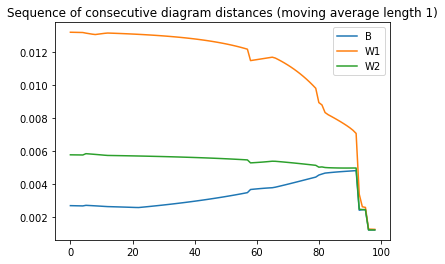

In [318]:
uexpe.plot_diagram_distances(dgms, 1)

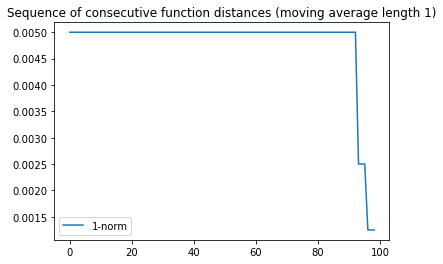

In [319]:
uexpe.plot_function_distances(funcs, 1)

### Saving. Bewayre you don't do stupid stuff. 

In [496]:
path = './save_repo/tR_N=%s_' %N
print(path)

./save_repo/tR_N=4_


In [497]:
np.save(path + 'diags.npy', dgms)
np.save(path + 'losses.npy', topomean.losseslist)
np.save(path + 'grads_norms.npy', np.array([g[1] for g in gradients]))
np.save(path + 'grads_values.npy', np.array([g[0] for g in gradients]))
np.save(path + 'funcs.npy', funcs)

In [498]:
np.save(path + 'target.npy', F)
np.save(path + 'target_diagram.npy', L[0])